## **Parallel Workflow**
### **UPSC Essay Evaluation**
```
            /---> Clarity of Thought (LLM) Score  ---> \
START -----<>---> Depth of Analysis (LLM) Score   --->  >---> Final Evaluation (LLM)  >---> Summary Feedback (Avg Score) >---> END
            \---> Quality of Language (LLM) Score ---> /
```
- Parallel
- Structured Output
- Reducer Function

In [1]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from typing import TypedDict, List, Annotated
from pydantic import BaseModel, Field
import operator

In [2]:
# ---------------- MODEL ---------------- #

model = ChatOllama(
    model="llama3.2:1b",    # qwen2.5:0.5b
    temperature=0.3
)

# ---------------- STRUCTURED OUTPUT ---------------- #

class EvaluationSchema(BaseModel):
    feedback: str = Field(
        description="Clear, constructive, and specific feedback explaining strengths and weaknesses."
    )
    score: int = Field(
        description="An integer score between 0 and 10.",
        ge=0,
        le=10
    )

structured_model = model.with_structured_output(EvaluationSchema)

In [3]:
# ---------------- STATE ---------------- #

class UPSCState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[List[int], operator.add]
    avg_score: float

In [4]:
# ---------------- EVALUATION FUNCTIONS ---------------- #

def evaluate_language(state: UPSCState):
    prompt = (
        "Evaluate the essay strictly on LANGUAGE QUALITY.\n"
        "Focus on grammar, vocabulary, sentence structure, tone, and fluency.\n"
        "Provide detailed feedback and assign a score out of 10.\n\n"
        f"Essay:\n{state['essay']}"
    )

    output = structured_model.invoke(prompt)

    return {
        "language_feedback": output.feedback,
        "individual_scores": [output.score]
    }


def evaluate_analysis(state: UPSCState):
    prompt = (
        "Evaluate the essay strictly on DEPTH OF ANALYSIS.\n"
        "Focus on argument strength, critical thinking, use of examples, and logical reasoning.\n"
        "Provide detailed feedback and assign a score out of 10.\n\n"
        f"Essay:\n{state['essay']}"
    )

    output = structured_model.invoke(prompt)

    return {
        "analysis_feedback": output.feedback,
        "individual_scores": [output.score]
    }


def evaluate_clarity(state: UPSCState):
    prompt = (
        "Evaluate the essay strictly on CLARITY OF THOUGHT.\n"
        "Focus on coherence, organization, flow of ideas, and clarity of expression.\n"
        "Provide detailed feedback and assign a score out of 10.\n\n"
        f"Essay:\n{state['essay']}"
    )

    output = structured_model.invoke(prompt)

    return {
        "clarity_feedback": output.feedback,
        "individual_scores": [output.score]
    }


def final_evaluation(state: UPSCState):
    prompt = (
        "You are an UPSC essay evaluator.\n"
        "Based on the following feedback sections, write a concise and balanced overall evaluation.\n\n"
        f"Language Feedback:\n{state['language_feedback']}\n\n"
        f"Analysis Feedback:\n{state['analysis_feedback']}\n\n"
        f"Clarity Feedback:\n{state['clarity_feedback']}"
    )

    overall_feedback = model.invoke(prompt).content

    avg_score = sum(state["individual_scores"]) / len(state["individual_scores"])

    return {
        "overall_feedback": overall_feedback,
        "avg_score": round(avg_score, 2)
    }


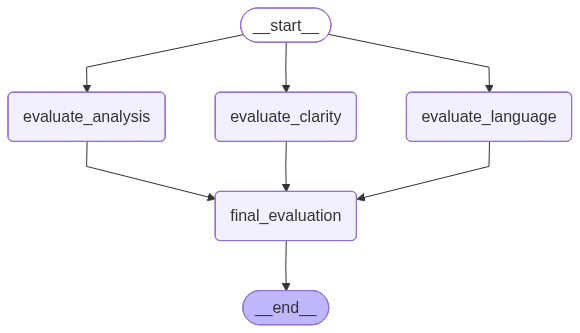

In [5]:
graph = StateGraph(UPSCState)

# Nodes
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_analysis', evaluate_analysis)
graph.add_node('evaluate_clarity', evaluate_clarity)
graph.add_node('final_evaluation', final_evaluation)

# Edges
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_analysis')
graph.add_edge(START, 'evaluate_clarity')

graph.add_edge('evaluate_language', 'final_evaluation')
graph.add_edge('evaluate_analysis', 'final_evaluation')
graph.add_edge('evaluate_clarity', 'final_evaluation')

graph.add_edge('final_evaluation', END)

workflow = graph.compile()
workflow


In [6]:
essay = """
The impact of Artificial Intelligence (AI) in India has been profound and multifaceted, reflecting the country's rapid technological advancements and its aspirations to become a global leader in the digital economy. As AI technologies continue to evolve, India is poised to harness their potential across various sectors, driving innovation, efficiency, and economic growth.
One of the most significant impacts of AI in India is in the realm of economic growth and job creation. AI has the potential to contribute significantly to India's GDP, with predictions suggesting it could add up to $450-500 billion by 2025. This growth is expected to create numerous job opportunities, particularly in sectors like IT, healthcare, finance, and manufacturing. However, this also necessitates upskilling the workforce to meet the demands of a rapidly evolving job market.
In healthcare, AI is revolutionizing patient care and diagnostics. AI-powered tools are being used to analyze medical images, diagnose diseases, and predict patient outcomes. This not only improves the accuracy of diagnoses but also enhances the efficiency of healthcare services, making them more accessible to a broader population.
AI is also transforming India's agricultural sector, which employs a significant portion of the population. AI-driven precision farming techniques are helping farmers optimize crop yields, reduce waste, and make informed decisions about planting and harvesting. This can lead to increased productivity and better food security.
Furthermore, AI is enhancing governance and public services in India. Initiatives like digital identity management and AI-driven grievance redressal systems are improving transparency and efficiency in government operations. AI-powered chatbots are being used to provide citizens with quick and accurate responses to their queries, making government services more accessible.
However, the adoption of AI in India also raises important questions about data privacy, security, and ethical use. Ensuring that AI systems are designed and deployed responsibly is crucial to building trust and maximizing their benefits.
In conclusion, AI has the potential to be a game-changer for India, driving growth, improving services, and enhancing the quality of life for its citizens. By focusing on ethical AI practices, investing in skill development, and fostering innovation, India can position itself at the forefront of the AI revolution.
"""


initial_state = {
    'essay': essay
}

response = workflow.invoke(initial_state)
response


{'essay': "\nThe impact of Artificial Intelligence (AI) in India has been profound and multifaceted, reflecting the country's rapid technological advancements and its aspirations to become a global leader in the digital economy. As AI technologies continue to evolve, India is poised to harness their potential across various sectors, driving innovation, efficiency, and economic growth.\nOne of the most significant impacts of AI in India is in the realm of economic growth and job creation. AI has the potential to contribute significantly to India's GDP, with predictions suggesting it could add up to $450-500 billion by 2025. This growth is expected to create numerous job opportunities, particularly in sectors like IT, healthcare, finance, and manufacturing. However, this also necessitates upskilling the workforce to meet the demands of a rapidly evolving job market.\nIn healthcare, AI is revolutionizing patient care and diagnostics. AI-powered tools are being used to analyze medical imag

In [7]:
essay2 = """
India's democratic growth is a remarkable story of resilience, diversity, and the triumph of its people. Since gaining independence in 1947, India has established itself as the world's largest democracy, with a robust constitution, vibrant institutions, and an engaged citizenry.
One key factor driving India's democratic growth is its commitment to inclusivity. The Constitution guarantees fundamental rights, equality, and justice for all citizens, regardless of caste, creed, or gender. This has enabled marginalized groups to participate in the democratic process, contributing to social and economic empowerment.
Free and fair elections are another cornerstone of India's democracy. Regular elections at national, state, and local levels ensure accountability and give citizens a voice in governance. Institutions like the Election Commission have played a crucial role in maintaining the integrity of the electoral process.
India's federal structure has also contributed to its democratic growth, allowing states to address local issues and promoting decentralization. This has fostered innovation and competition among states, driving policy reforms and development.
The media and civil society play a vital role in holding those in power accountable, ensuring transparency, and promoting public discourse. Landmark legislation like the Right to Information Act has empowered citizens to demand accountability from the government.
Despite challenges like corruption, communalism, and economic disparities, India's democracy has shown resilience and adaptability. Reforms and initiatives have addressed these issues, reflecting the system's ability to evolve and self-correct.
In conclusion, India's democratic growth is a testament to the strength of its institutions, the resilience of its people, and its commitment to inclusivity and accountability. As India continues to grow and evolve, its democracy will remain a cornerstone of its progress.
"""

initial_state = {
    'essay': essay2
}

response2 = workflow.invoke(initial_state)
response2

{'essay': "\nIndia's democratic growth is a remarkable story of resilience, diversity, and the triumph of its people. Since gaining independence in 1947, India has established itself as the world's largest democracy, with a robust constitution, vibrant institutions, and an engaged citizenry.\nOne key factor driving India's democratic growth is its commitment to inclusivity. The Constitution guarantees fundamental rights, equality, and justice for all citizens, regardless of caste, creed, or gender. This has enabled marginalized groups to participate in the democratic process, contributing to social and economic empowerment.\nFree and fair elections are another cornerstone of India's democracy. Regular elections at national, state, and local levels ensure accountability and give citizens a voice in governance. Institutions like the Election Commission have played a crucial role in maintaining the integrity of the electoral process.\nIndia's federal structure has also contributed to its 

In [8]:
essay3 = """
Technology is like, super important, yaar. Its everywhere, in our phones, laptops, tabs, even in our watches, haha. People are using it alot, like for study, work, even for chit chat with frnds. Its like, makes life super easy, but also kinda complicated, you know?
In India, technology is growing so fast, like AI, ML, all that stuff. Its like, helping in healthcare, agriculture, even in government services, yaar. People are getting jobs, startups are happening, its like, boom!
But, its also like, has some cons, na. Like, people are getting too much addicted to phones, social media, all that. And, cybercrime is also like, increasing, so much, scary, yaar.
So, technology is like, good, bad, everything, you know? We should like, use it wisely, not get too much into it, haha. Thats it, i think.
"""

initial_state = {
    'essay': essay3
}

response3 = workflow.invoke(initial_state)
response3

{'essay': '\nTechnology is like, super important, yaar. Its everywhere, in our phones, laptops, tabs, even in our watches, haha. People are using it alot, like for study, work, even for chit chat with frnds. Its like, makes life super easy, but also kinda complicated, you know?\nIn India, technology is growing so fast, like AI, ML, all that stuff. Its like, helping in healthcare, agriculture, even in government services, yaar. People are getting jobs, startups are happening, its like, boom!\nBut, its also like, has some cons, na. Like, people are getting too much addicted to phones, social media, all that. And, cybercrime is also like, increasing, so much, scary, yaar.\nSo, technology is like, good, bad, everything, you know? We should like, use it wisely, not get too much into it, haha. Thats it, i think.\n',
 'language_feedback': 'grammar',
 'analysis_feedback': 'low',
 'clarity_feedback': 'The essay has a good flow and structure, with each paragraph building upon the previous one to